# Differentiation matrices

Now we return to the example of indefinite integration we used at the beginning of the chapter,

$$
u'(x) = g(x), \quad u(a)=0, \quad a < x < b. 
$$

If we discretize the domain $[a,b]$ by the nodes

$$
x_i = a + ih, \quad h = \frac{b-a}{n}, \quad i=0,\ldots,n,
$$

then we were able to summarize imposing the ODE at the nodes through a linear system starting with the differentiation matrix

$$
\bfD_x = 
\frac{1}{2h}
\begin{bmatrix} 
-2 & 2 & & & \\ 
-1 & 0 & 1 & & \\ 
& \ddots & \ddots & \ddots  & \\ 
& & -1 & 0 & 1 \\ 
& & & -2 & 2 
\end{bmatrix}.
$$

We can likewise build a differentiation matrix for the second derivative,

$$
\bfD_{xx} = \frac{1}{h^2}  \begin{bmatrix} 
1 & -2 & 1 & & & \\ 
1 & -2 & 1 & & & \\ 
0 & 1 & -2 & 1 & & \\ 
& & \ddots & \ddots & \ddots & \\ 
& & & 1 & -2 & 1 \\
& & & 1 & -2 & 1 
\end{bmatrix}
$$

In [1]:
using LinearAlgebra
function diffmats(x)
    # assumes evenly spaced nodes
    h = x[2]-x[1]
    m = length(x)
    Dx = 1/2h*diagm(-1=>[-ones(m-2);-2],0=>[-2;zeros(m-2);2],1=>[2;ones(m-2)])
    Dxx = 1/h^2*diagm(-1=>[ones(m-2);-2],0=>[1;-2*ones(m-2);1],1=>[-2;ones(m-2)])
    Dxx[m,m-2] = Dxx[1,3] = 1/h^2
    return Dx,Dxx
end

diffmats (generic function with 1 method)

It's unfortunate that the first and last rows in each differentiation matrix are first-order accurate, while the others are all second-order. However, in practice this often turns out not to matter.

The problem

$$
u''(x) = f(x)
$$

is solved by integrating twice. The two integration constants have to be specified by initial or boundary conditions. We'll suppose that $u(0)=0$ and $u(1)=-1$. Define the *chopping matrix* $\bfC$ as an identity matrix with its first and last rows removed. Then we can express the BVP as

$$
\begin{bmatrix}
\begin{bmatrix}
  1 & 0 & \cdots & 0 
\end{bmatrix}
\\ \bfC \bfD_{xx} \\ 
\begin{bmatrix}
  0 & \cdots & 0 & 1
\end{bmatrix}
\end{bmatrix} 
= 
\begin{bmatrix}
  0 \\ \bfC\bff \\ -1
\end{bmatrix}. 
$$

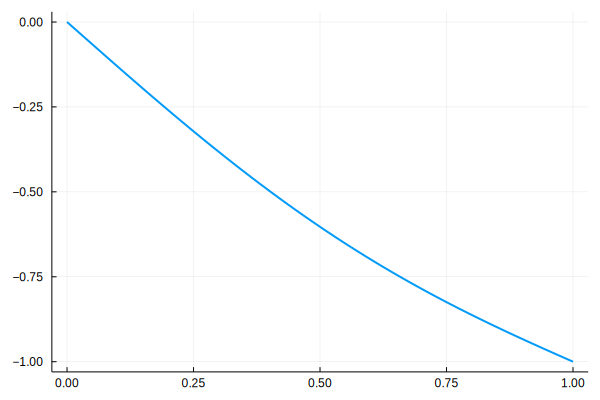

In [2]:
a,b = 0,1
g(x) = sin(3x)
n = 120
h = (b-a)/n
x = [a + i*h for i in 0:n]
_,Dxx = diffmats(x)
A = [ [1 zeros(1,n)]; Dxx[2:n,:]; [zeros(1,n) 1] ]
f = [ 0; g.(x[2:n]); -1]
u = A\f

using Plots
plot(x,u)